# 1. Import libraries

In [1]:
# data manipulation
import numpy as np
import pandas as pd
from darts import TimeSeries

# data visualization
import matplotlib.pyplot as plt

# transformers and preprocessing pipeline
from darts.dataprocessing.transformers import Scaler, BoxCox
from darts.dataprocessing import Pipeline

# models
from darts.models import NaiveSeasonal, RegressionModel, TFTModel
from sklearn.linear_model import BayesianRidge

# likelihood
from darts.utils.likelihood_models import QuantileRegression

# metrics
from sklearn.metrics import mean_absolute_percentage_error

# warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
def take_backtest_horizon(backtests, horizon, last_horizon, observations, col):
    backtests_horizon_dates = [i[col].time_index[-1+horizon] for i in backtests[last_horizon-horizon:][:observations]]
    backtests_horizon_values = [i[col].values()[-1+horizon] for i in backtests[last_horizon-horizon:][:observations]]
    
    backtests_horizon = TimeSeries.from_times_and_values(times=pd.DatetimeIndex(backtests_horizon_dates), values=np.array(backtests_horizon_values))
    return backtests_horizon

In [3]:
def BIAS(y_true, y_pred):
    bias = (((np.sum(y_pred - y_true))/(np.sum(y_true))))
    return bias

# 2. Load data

In [4]:
dataset = pd.read_csv('../results/prepared_data.csv')

# set the column type for column with date
dataset['Data'] = pd.to_datetime(dataset['Data'], format='%Y-%m-%d')

dataset

,Data,GŁOGÓW (151160060) Stan wody [cm],RACIBÓRZ-MIEDONIA (150180060) Stan wody [cm],BARDO ŚLĄSKIE (250160410) Suma opadów [mm],BIERUTÓW (251170270) Suma opadów [mm],BOLESŁAWÓW (250160610) Suma opadów [mm],BOLKÓW (250160030) Suma opadów [mm],BORÓW (250160070) Suma opadów [mm],BRZEG (250170050) Suma opadów [mm],BRZEG DOLNY (251160230) Suma opadów [mm],...,WALIM (250160270) Suma opadów [mm],WROCŁAW-STRACHOWICE (351160424) Suma opadów [mm],ZIELENIEC (250160530) Suma opadów [mm],ZIELINA (250170280) Suma opadów [mm],ŹRÓDŁA (251160370) Suma opadów [mm],średnia Suma opadów [mm],mediana Suma opadów [mm],std Suma opadów [mm],min Suma opadów [mm],max Suma opadów [mm]
0,2012-01-01,199.0,119.0,0.2,0.5,0.5,0.7,0.2,NaN,0.8,...,0.0,0.3,7.0,0.5,NaN,0.721875,0.5,1.011152,1.004099,0.997161
1,2012-01-02,197.0,116.0,NaN,1.1,1.0,0.8,0.0,0.3,0.6,...,0.1,0.2,1.3,NaN,NaN,0.888889,0.6,0.975195,0.967729,0.960422
2,2012-01-03,197.0,118.0,2.2,0.9,5.6,NaN,0.0,NaN,0.1,...,0.2,0.1,9.5,NaN,NaN,1.406667,0.2,2.389560,2.373573,2.357783
3,2012-01-04,204.0,127.0,2.4,0.1,12.5,NaN,NaN,0.6,0.5,...,5.2,0.0,12.6,0.9,NaN,3.620270,1.5,4.469327,4.440950,4.413037
4,2012-01-05,205.0,153.0,8.9,7.1,23.0,10.2,0.5,1.0,3.0,...,12.9,2.5,46.0,6.1,NaN,10.271795,7.1,9.973365,9.910877,9.849571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3648,2021-12-27,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,NaN,0.000000,0.0,0.000000,0.000000,0.000000
3649,2021-12-28,NaN,NaN,2.4,0.0,2.8,1.2,5.7,3.1,2.8,...,0.2,3.5,6.7,4.5,3.8,2.206579,2.1,1.847490,1.836050,1.824848
3650,2021-12-29,NaN,NaN,0.2,2.3,0.0,0.5,0.7,1.0,0.5,...,0.0,1.3,3.2,1.1,0.9,0.562500,0.5,0.635832,0.631579,0.627404
3651,2021-12-30,NaN,NaN,1.6,6.2,2.0,3.4,4.4,5.5,4.7,...,1.5,4.6,10.2,5.6,4.2,4.215789,4.2,2.810743,2.797137,2.783785


In [5]:
hierarchy = pd.read_csv('../results/prepared_hierarchy.csv')

hierarchy

,id_meteo,name_meteo,id_hydro,name_hydro
0,251160080,GŁOGÓW,151160060,GŁOGÓW
1,350180540,RACIBÓRZ,150180060,RACIBÓRZ-MIEDONIA


In [6]:
hydro_cols = [f"{stations['name_hydro']} ({stations['id_hydro']}) Stan wody [cm]" for _, stations in hierarchy.loc[
                                            :, ['id_hydro', 'name_hydro']].drop_duplicates().iterrows()]

meteo_common_cols = ['średnia Suma opadów [mm]', 'mediana Suma opadów [mm]', 'std Suma opadów [mm]', 'min Suma opadów [mm]', 
                     'max Suma opadów [mm]']

# 3. Save as TimeSeries Object

In [7]:
dataset_ts = TimeSeries.from_dataframe(df=dataset.loc[:, ['Data']+hydro_cols].dropna(),
                                       time_col='Data', value_cols=hydro_cols)

dataset_ts

<TimeSeries (DataArray) (Data: 3592, component: 2, sample: 1)>
array([[[199.],
        [119.]],

       [[197.],
        [116.]],

       [[197.],
        [118.]],

       ...,

       [[214.],
        [124.]],

       [[208.],
        [122.]],

       [[209.],
        [121.]]])
Coordinates:
  * Data       (Data) datetime64[ns] 2012-01-01 2012-01-02 ... 2021-10-31
  * component  (component) object 'GŁOGÓW (151160060) Stan wody [cm]' 'RACIBÓ...
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [8]:
def encode_time(X, col):
    X[col + '_sin'] = np.sin(2 * np.pi * X[col].dt.dayofyear/X[col].dt.dayofyear.max())
    X[col + '_cos'] = np.cos(2 * np.pi * X[col].dt.dayofyear/X[col].dt.dayofyear.max())
    return X

In [9]:
covariates = dataset[['Data']+meteo_common_cols].copy()

# Add info about seasonality
covariates = encode_time(covariates, 'Data')
seasonality_cols = ['Data_sin', 'Data_cos']

covariates = TimeSeries.from_dataframe(df=covariates, time_col='Data', value_cols=meteo_common_cols+seasonality_cols)

covariates

<TimeSeries (DataArray) (Data: 3653, component: 7, sample: 1)>
array([[[ 0.721875  ],
        [ 0.5       ],
        [ 1.0111521 ],
        ...,
        [ 0.99716118],
        [ 0.01716633],
        [ 0.99985265]],

       [[ 0.88888889],
        [ 0.6       ],
        [ 0.97519545],
        ...,
        [ 0.96042222],
        [ 0.0343276 ],
        [ 0.99941063]],

       [[ 1.40666667],
        [ 0.2       ],
        [ 2.38956026],
        ...,
...
        ...,
        [ 0.62740441],
        [-0.05147875],
        [ 0.99867409]],

       [[ 4.21578947],
        [ 4.2       ],
        [ 2.81074307],
        ...,
        [ 2.78378499],
        [-0.0343276 ],
        [ 0.99941063]],

       [[ 1.94473684],
        [ 1.3       ],
        [ 2.07345076],
        ...,
        [ 2.047139  ],
        [-0.01716633],
        [ 0.99985265]]])
Coordinates:
  * Data       (Data) datetime64[ns] 2012-01-01 2012-01-02 ... 2021-12-31
  * component  (component) object 'średnia Suma opadów [mm]' ... 'Data_cos'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

# 3. Train Test Split & pre-processing

In [10]:
first_test_date = dataset.loc[:, ['Data']+hydro_cols].dropna()['Data'].values[-180] # Last 6 months in test set
first_test_date = pd.Timestamp(first_test_date)
first_test_date

Timestamp('2021-05-05 00:00:00')

In [11]:
train_dataset, test_dataset = dataset_ts.split_before(first_test_date)

boxcox = BoxCox()
scaler = Scaler()
pipeline_preprocessing = Pipeline([boxcox, scaler])

train_dataset_prepared = pipeline_preprocessing.fit_transform(train_dataset)
test_dataset_prepared = pipeline_preprocessing.transform(test_dataset)

pipeline_preprocessing_all = Pipeline([boxcox, scaler])
dataset_ts_prepared = pipeline_preprocessing_all.fit_transform(dataset_ts)

In [12]:
scaler_covariates = Scaler()
scaler_covariates.fit(covariates.split_before(first_test_date)[0])
covariates_prepared = scaler_covariates.transform(covariates)

scaler_covariates_all = Scaler()
covariates_all_prepared = scaler_covariates_all.fit_transform(covariates)

# 4. Modelling & Backtests

In [13]:
# Założenie, że max horyzont to t0+30 days
horizons = 30

In [14]:
first_test_date - np.timedelta64(horizons-1, 'D')

Timestamp('2021-04-06 00:00:00')

## 4.1 Baseline

In [15]:
def create_df_forecast_metrics(target_cols, model_name, variable, last_horizon, backtests, test_set):
    historical_forecasts = {}
    metrics = {}
    
    for target in hydro_cols:
        historical_forecasts[target] = pd.DataFrame()
        historical_forecasts[target].index = test_dataset.time_index
        historical_forecasts[target]['Model'] = model_name
        historical_forecasts[target]['Stacja'] = target
        historical_forecasts[target]['Zmienne'] = variable

        metrics[target] = pd.DataFrame()
        metrics[target].index = [f'Forecast_-{horizon}D' for horizon in range(1, last_horizon+1)]
        metrics[target]['Model'] = model_name
        metrics[target]['Stacja'] = target
        metrics[target]['Zmienne'] = None

        for horizon in range(1, last_horizon+1):
            # Forecast for selected horizon
            historical_forecasts[target][
                f'Forecast_-{horizon}D'] = take_backtest_horizon(
                    backtests=backtests, horizon=horizon, last_horizon=last_horizon, 
                    observations=len(test_set), col=target).values()
            # evaluation metric for selected horizon on test set
            metrics[target].loc[f'Forecast_-{horizon}D', 'MAPE'] = mean_absolute_percentage_error(
                y_true=test_set[target].values(), y_pred=historical_forecasts[target][f'Forecast_-{horizon}D'].values)
            metrics[target].loc[f'Forecast_-{horizon}D', 'BIAS'] = BIAS(
                y_true=test_set[target].values(), y_pred=historical_forecasts[target][f'Forecast_-{horizon}D'].values)
    return historical_forecasts, metrics

In [16]:
def make_forecast(model, last_horizon, model_name, variable, past_covariates=None, future_covariates=None, pipeline_prep=None):
    if (past_covariates==None)&(future_covariates==None):
        forecast = model.predict(last_horizon)
    else:
        forecast = model.predict(last_horizon, past_covariates=past_covariates, future_covariates=future_covariates)
    if pipeline_prep!=None:
        forecast = pipeline_prep.inverse_transform(forecast)
        
    forecast = forecast.pd_dataframe().reset_index(drop=False)
    forecast.columns.name = None

    forecast['Model'] = model_name
    forecast['Zmienne'] = variable
    
    return forecast

In [17]:
def viz_forecast(forecast, historic_data, len_historic_data, target):
    plt.figure(figsize=(16, 7))

    plt.plot(historic_data[target].time_index[-len_historic_data:], 
             historic_data[target].values()[-len_historic_data:],
             label=f'Dane historyczne')
    plt.plot(forecast['Data'], 
             forecast[target], label=f'Forecast')

    plt.legend(loc='upper right')
    plt.show()

In [18]:
def viz_backtest(metrics, test_set, historic_forecast, horizon_to_viz, target_to_viz):
    print(f"MAPE: {np.round(metrics[target_to_viz].loc[f'Forecast_-{horizon_to_viz}D', 'MAPE'], 3)}")
    print(f"BIAS: {np.round(metrics[target_to_viz].loc[f'Forecast_-{horizon_to_viz}D', 'BIAS'], 3)}")
    plt.figure(figsize=(16, 7))

    plt.plot(test_set[target_to_viz].time_index, test_set[target_to_viz].values(), label='Wartość prawdziwa')
    plt.plot(historic_forecast[target_to_viz].index, 
             historic_forecast[target_to_viz][f'Forecast_-{horizon_to_viz}D'], label=f'Prognoza -{horizon_to_viz}D')

    plt.legend(loc='upper right')
    plt.show()

In [19]:
baseline_model = NaiveSeasonal(1)

baseline_model.fit(series=train_dataset)

backtests_baseline = baseline_model.historical_forecasts(series=dataset_ts,
                                                         past_covariates=None,
                                                         future_covariates=None,
                                                         start=first_test_date - np.timedelta64(horizons-1, 'D'), 
                                                         verbose=False, 
                                                         overlap_end=True,
                                                         last_points_only=False, 
                                                         forecast_horizon=horizons,
                                                         retrain=True)
baseline_model.fit(dataset_ts)
baseline_forecast = make_forecast(model=baseline_model, last_horizon=horizons, model_name='Baseline', variable=None)

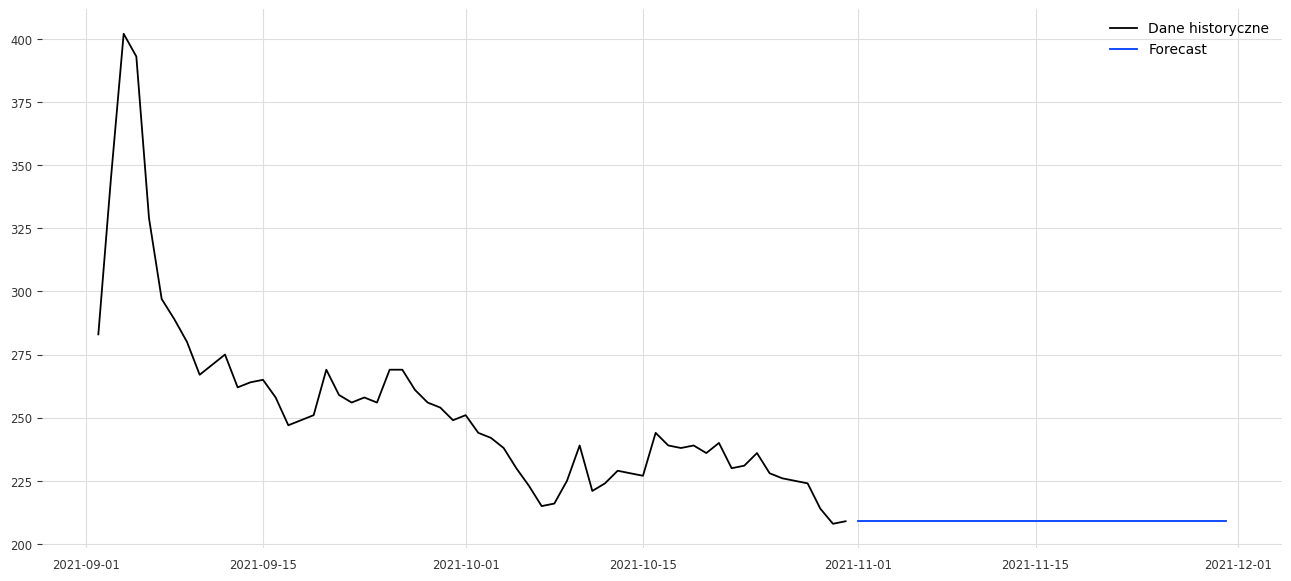

In [20]:
viz_forecast(forecast=baseline_forecast, len_historic_data=60, historic_data=dataset_ts,
             target='GŁOGÓW (151160060) Stan wody [cm]')

In [21]:
baseline_historical_forecasts, baseline_metrics = create_df_forecast_metrics(
    target_cols=hydro_cols, 
    model_name='Baseline',
    variable=None,
    last_horizon=horizons, 
    backtests=backtests_baseline,
    test_set=test_dataset)

MAPE: 0.135
BIAS: 3.052


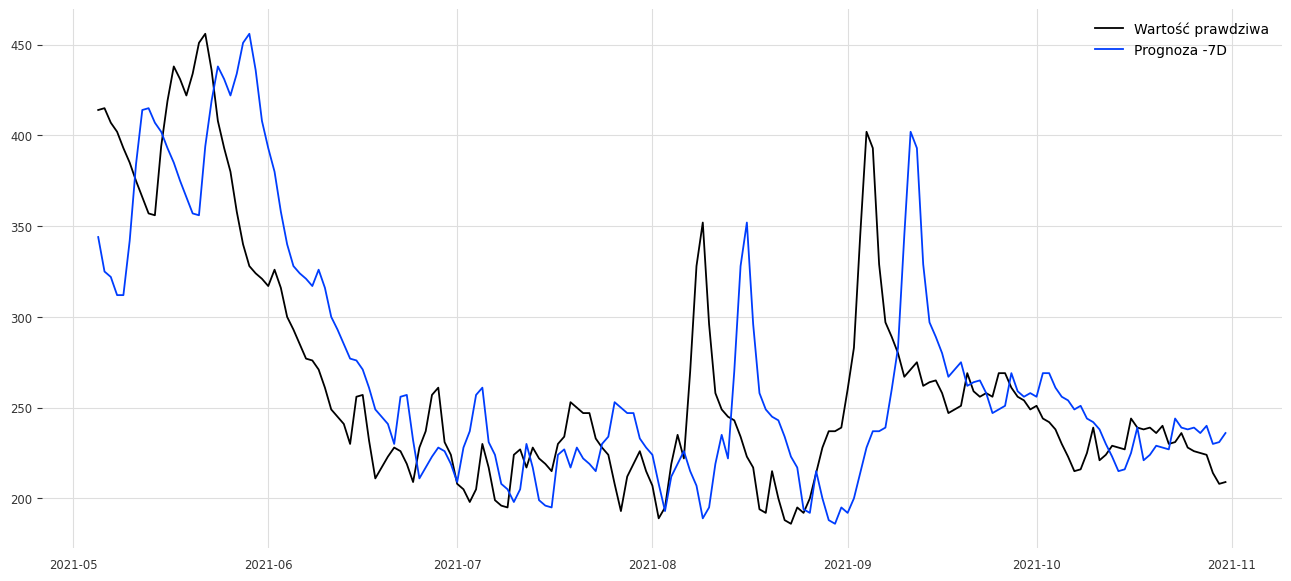

In [22]:
viz_backtest(metrics=baseline_metrics, 
             test_set=test_dataset,
             historic_forecast=baseline_historical_forecasts,
             horizon_to_viz=7,
             target_to_viz='GŁOGÓW (151160060) Stan wody [cm]')

## 4.2 BayesianRidge

### 4.2.1 Past-observed covariates

In [23]:
br_model_past_cov = RegressionModel(lags=7, lags_past_covariates=7, lags_future_covariates=[0],
                                    model=BayesianRidge())

br_model_past_cov.fit(series=train_dataset_prepared, 
                      past_covariates=covariates_prepared, 
                      future_covariates=covariates_prepared[seasonality_cols])

backtests_br_past_cov = br_model_past_cov.historical_forecasts(series=dataset_ts_prepared,
                                                               past_covariates=covariates_prepared,
                                                               future_covariates=covariates_prepared[seasonality_cols],
                                                               start=first_test_date - np.timedelta64(horizons-1, 'D'), 
                                                               verbose=False, 
                                                               overlap_end=True,
                                                               last_points_only=False, 
                                                               forecast_horizon=horizons,
                                                               retrain=True)
backtests_br_past_cov = [pipeline_preprocessing.inverse_transform(backtest) for backtest in backtests_br_past_cov]


br_model_past_cov.fit(series=dataset_ts_prepared, 
                      past_covariates=covariates_all_prepared, 
                      future_covariates=covariates_all_prepared[seasonality_cols])

br_past_cov_forecast = make_forecast(model=br_model_past_cov, last_horizon=horizons, model_name='BayesianRidge',
                                     variable='Past',
                                     past_covariates=covariates_all_prepared, 
                                     future_covariates=covariates_all_prepared[seasonality_cols], 
                                     pipeline_prep=pipeline_preprocessing_all)

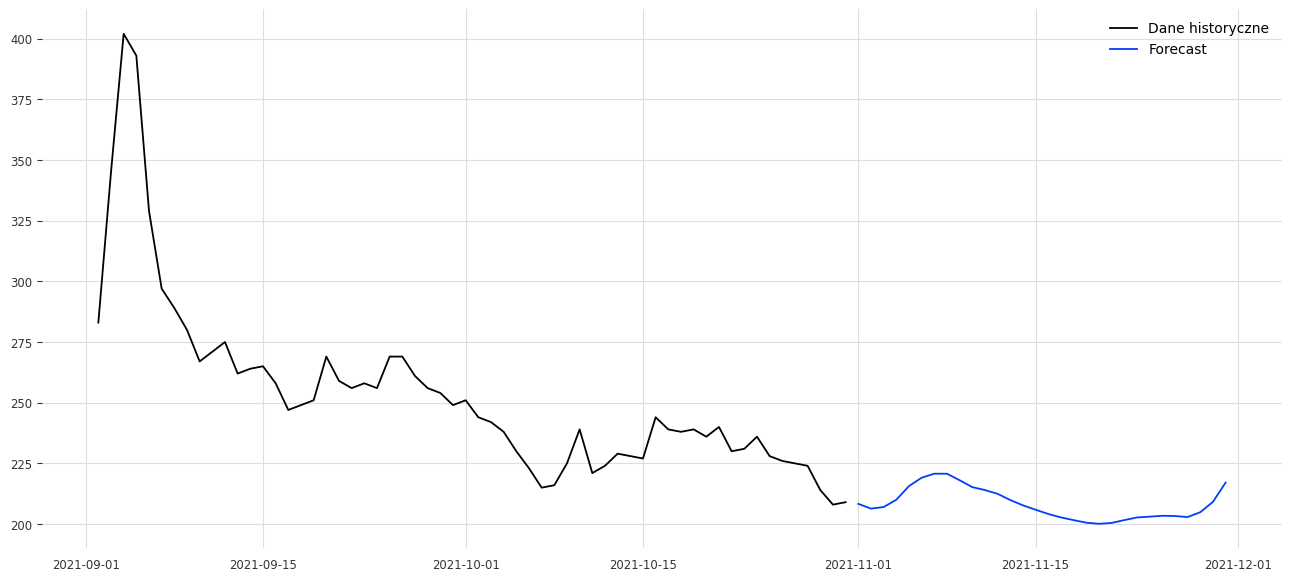

In [24]:
viz_forecast(forecast=br_past_cov_forecast, len_historic_data=60, historic_data=dataset_ts,
             target='GŁOGÓW (151160060) Stan wody [cm]')

In [25]:
br_past_cov_historical_forecasts, br_past_cov_metrics = create_df_forecast_metrics(
    target_cols=hydro_cols, 
    model_name='Bayesian Ridge',
    variable='Past',
    last_horizon=horizons,
    backtests=backtests_br_past_cov,
    test_set=test_dataset)

MAPE: 0.067
BIAS: -1.208


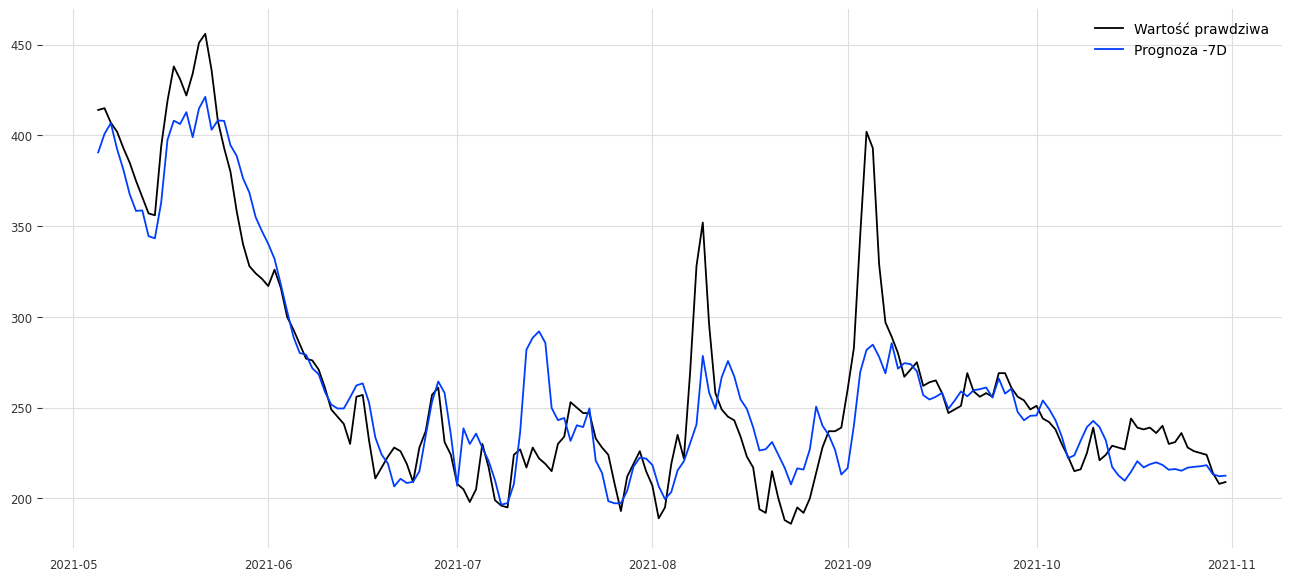

In [26]:
viz_backtest(metrics=br_past_cov_metrics, 
             test_set=test_dataset,
             historic_forecast=br_past_cov_historical_forecasts,
             horizon_to_viz=7,
             target_to_viz='GŁOGÓW (151160060) Stan wody [cm]')

### 4.2.2 Past-observed covariates + Future-known covariates

In [27]:
br_model_past_future_cov = RegressionModel(lags=7, lags_past_covariates=7, 
                                           lags_future_covariates=(7, 0),
                                           model=BayesianRidge())

br_model_past_future_cov.fit(series=train_dataset_prepared, 
                             past_covariates=covariates_prepared, 
                             future_covariates=covariates_prepared)

backtests_br_past_future_cov = br_model_past_future_cov.historical_forecasts(series=dataset_ts_prepared,
                                                                             past_covariates=covariates_prepared,
                                                                             future_covariates=covariates_prepared,
                                                                             start=first_test_date - np.timedelta64(horizons-1,
                                                                                                                    'D'), 
                                                                             verbose=False,
                                                                             overlap_end=True,
                                                                             last_points_only=False, 
                                                                             forecast_horizon=horizons,
                                                                             retrain=True)
backtests_br_past_future_cov = [pipeline_preprocessing.inverse_transform(backtest) for backtest in backtests_br_past_future_cov]


br_model_past_future_cov.fit(series=dataset_ts_prepared, 
                             past_covariates=covariates_all_prepared, 
                             future_covariates=covariates_all_prepared)

br_past_future_cov_forecast = make_forecast(model=br_model_past_future_cov, last_horizon=horizons, model_name='BayesianRidge', 
                                            variable='Past+Future',
                                            past_covariates=covariates_all_prepared, 
                                            future_covariates=covariates_all_prepared, 
                                            pipeline_prep=pipeline_preprocessing_all)

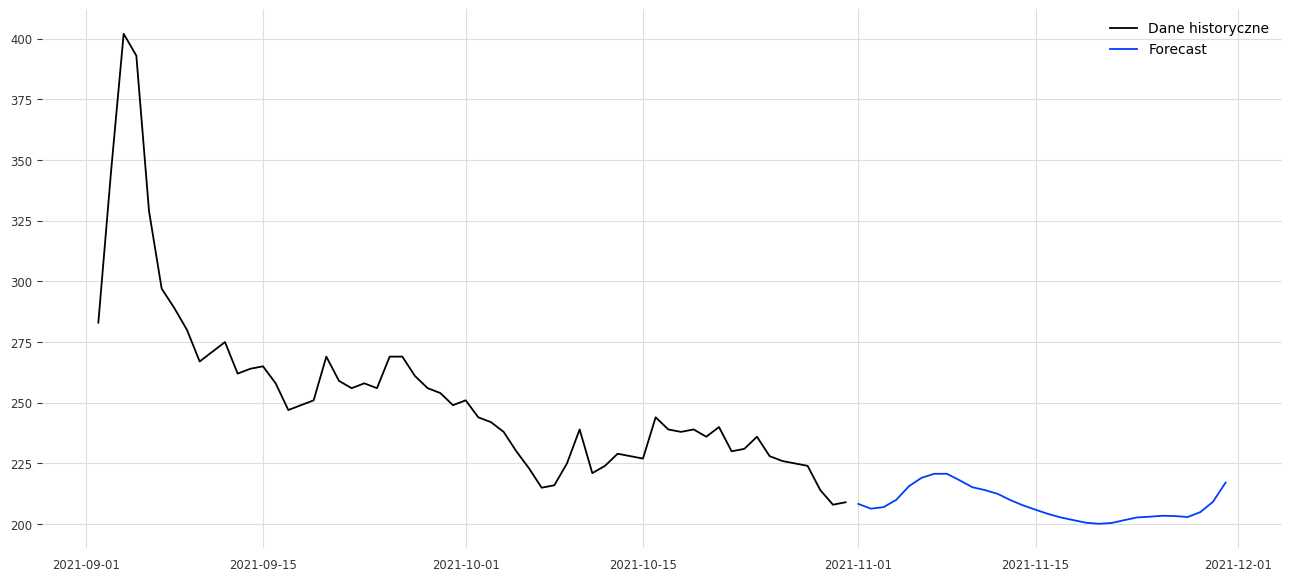

In [28]:
viz_forecast(forecast=br_past_future_cov_forecast, len_historic_data=60, historic_data=dataset_ts,
             target='GŁOGÓW (151160060) Stan wody [cm]')

In [29]:
br_past_future_cov_historical_forecasts, br_past_future_cov_metrics = create_df_forecast_metrics(
    target_cols=hydro_cols, 
    model_name='Bayesian Ridge',
    variable='Past+Future',
    last_horizon=horizons,
    backtests=backtests_br_past_future_cov,
    test_set=test_dataset)

MAPE: 0.067
BIAS: -1.212


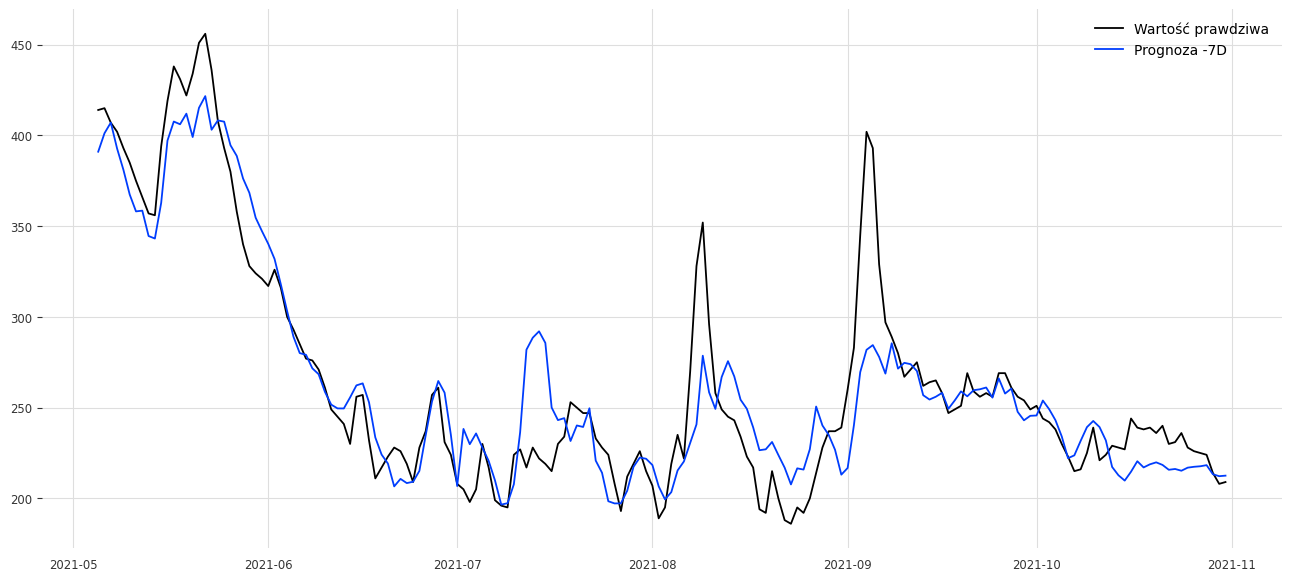

In [30]:
viz_backtest(metrics=br_past_future_cov_metrics, 
             test_set=test_dataset,
             historic_forecast=br_past_future_cov_historical_forecasts,
             horizon_to_viz=7,
             target_to_viz='GŁOGÓW (151160060) Stan wody [cm]')

# 5. Save Results

In [32]:
models_metrics = pd.DataFrame()
models_historical_forecasts = pd.DataFrame()

for target in hydro_cols:
    # metrics
    models_metrics = pd.concat([models_metrics, 
                                baseline_metrics[target].reset_index().rename({'index': 'horizon'}, axis=1)], 
                               axis=0)
    models_metrics = pd.concat([models_metrics, 
                                br_past_cov_metrics[target].reset_index().rename({'index': 'horizon'}, axis=1)], 
                               axis=0)
    models_metrics = pd.concat([models_metrics,
                                br_past_future_cov_metrics[target].reset_index().rename({'index': 'horizon'}, axis=1)], 
                               axis=0)
    
    # historical forecasts
    models_historical_forecasts = pd.concat([models_historical_forecasts, 
                                             baseline_historical_forecasts[target].reset_index()], 
                                            axis=0)
    models_historical_forecasts = pd.concat([models_historical_forecasts,
                                             br_past_cov_historical_forecasts[target].reset_index()], 
                                            axis=0)
    models_historical_forecasts = pd.concat([models_historical_forecasts,
                                             br_past_future_cov_historical_forecasts[target].reset_index()], 
                                            axis=0)
    
models_historical_forecasts.reset_index(drop=True, inplace=True)
models_metrics.reset_index(drop=True, inplace=True)

In [33]:
models_historical_forecasts.to_csv('../results/historical_forecasts.csv', index=False)
models_historical_forecasts

,Data,Model,Stacja,Zmienne,Forecast_-1D,Forecast_-2D,Forecast_-3D,Forecast_-4D,Forecast_-5D,Forecast_-6D,...,Forecast_-21D,Forecast_-22D,Forecast_-23D,Forecast_-24D,Forecast_-25D,Forecast_-26D,Forecast_-27D,Forecast_-28D,Forecast_-29D,Forecast_-30D
0,2021-05-05,Baseline,GŁOGÓW (151160060) Stan wody [cm],None,384.000000,342.000000,312.000000,312.000000,322.000000,325.000000,...,292.000000,293.000000,296.000000,293.000000,298.000000,301.000000,297.000000,309.000000,303.000000,303.000000
1,2021-05-06,Baseline,GŁOGÓW (151160060) Stan wody [cm],None,414.000000,384.000000,342.000000,312.000000,312.000000,322.000000,...,296.000000,292.000000,293.000000,296.000000,293.000000,298.000000,301.000000,297.000000,309.000000,303.000000
2,2021-05-07,Baseline,GŁOGÓW (151160060) Stan wody [cm],None,415.000000,414.000000,384.000000,342.000000,312.000000,312.000000,...,318.000000,296.000000,292.000000,293.000000,296.000000,293.000000,298.000000,301.000000,297.000000,309.000000
3,2021-05-08,Baseline,GŁOGÓW (151160060) Stan wody [cm],None,407.000000,415.000000,414.000000,384.000000,342.000000,312.000000,...,340.000000,318.000000,296.000000,292.000000,293.000000,296.000000,293.000000,298.000000,301.000000,297.000000
4,2021-05-09,Baseline,GŁOGÓW (151160060) Stan wody [cm],None,402.000000,407.000000,415.000000,414.000000,384.000000,342.000000,...,365.000000,340.000000,318.000000,296.000000,292.000000,293.000000,296.000000,293.000000,298.000000,301.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1075,2021-10-27,Bayesian Ridge,RACIBÓRZ-MIEDONIA (150180060) Stan wody [cm],Past+Future,126.156752,126.350823,123.778459,122.636959,122.039878,121.657136,...,110.375771,113.144538,113.106182,112.477688,111.791379,111.449955,110.066843,109.241553,110.941430,111.554333
1076,2021-10-28,Bayesian Ridge,RACIBÓRZ-MIEDONIA (150180060) Stan wody [cm],Past+Future,123.567017,123.745512,123.911875,121.824185,120.906081,120.391790,...,109.519884,109.335213,111.966244,111.945966,111.360239,110.712710,110.399723,109.079938,108.299255,109.909869
1077,2021-10-29,Bayesian Ridge,RACIBÓRZ-MIEDONIA (150180060) Stan wody [cm],Past+Future,124.320296,121.656261,121.795770,121.896577,120.006362,119.221223,...,107.404689,108.426824,108.284208,110.785438,110.781181,110.234565,109.623361,109.336727,108.077036,107.337944
1078,2021-10-30,Bayesian Ridge,RACIBÓRZ-MIEDONIA (150180060) Stan wody [cm],Past+Future,121.877281,122.305155,120.158719,120.295020,120.407522,118.603333,...,107.439944,106.521109,107.497154,107.391354,109.776481,109.785826,109.274082,108.695786,108.432419,107.226415


In [34]:
models_metrics.to_csv('../results/models_metrics.csv', index=False)
models_metrics

,horizon,Model,Stacja,Zmienne,MAPE,BIAS
0,Forecast_-1D,Baseline,GŁOGÓW (151160060) Stan wody [cm],None,0.042244,0.661890
1,Forecast_-2D,Baseline,GŁOGÓW (151160060) Stan wody [cm],None,0.071494,1.168708
2,Forecast_-3D,Baseline,GŁOGÓW (151160060) Stan wody [cm],None,0.089273,1.539367
3,Forecast_-4D,Baseline,GŁOGÓW (151160060) Stan wody [cm],None,0.103604,1.872203
4,Forecast_-5D,Baseline,GŁOGÓW (151160060) Stan wody [cm],None,0.113078,2.239079
...,...,...,...,...,...,...
175,Forecast_-26D,Bayesian Ridge,RACIBÓRZ-MIEDONIA (150180060) Stan wody [cm],None,0.175394,-24.766794
176,Forecast_-27D,Bayesian Ridge,RACIBÓRZ-MIEDONIA (150180060) Stan wody [cm],None,0.176599,-25.294778
177,Forecast_-28D,Bayesian Ridge,RACIBÓRZ-MIEDONIA (150180060) Stan wody [cm],None,0.177656,-25.861589
178,Forecast_-29D,Bayesian Ridge,RACIBÓRZ-MIEDONIA (150180060) Stan wody [cm],None,0.179378,-26.326687


In [35]:
models_forecast = baseline_forecast.copy()
models_forecast.to_csv('../results/models_forecast.csv', index=False)
models_forecast

,Data,GŁOGÓW (151160060) Stan wody [cm],RACIBÓRZ-MIEDONIA (150180060) Stan wody [cm],Model,Zmienne
0,2021-11-01,209.0,121.0,Baseline,None
1,2021-11-02,209.0,121.0,Baseline,None
2,2021-11-03,209.0,121.0,Baseline,None
3,2021-11-04,209.0,121.0,Baseline,None
4,2021-11-05,209.0,121.0,Baseline,None
5,2021-11-06,209.0,121.0,Baseline,None
6,2021-11-07,209.0,121.0,Baseline,None
7,2021-11-08,209.0,121.0,Baseline,None
8,2021-11-09,209.0,121.0,Baseline,None
9,2021-11-10,209.0,121.0,Baseline,None
